# Assignment 1 Code - Lenet

In [1]:
import numpy as np
from datetime import datetime
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import os
from PIL import Image, ImageOps

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Vanilla LeNet-5

In [28]:
RANDOM_SEED = 73
LEARNING_RATE = 0.0001
BATCH_SIZE = 8
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

In [3]:
class LeNet(nn.Module):
    def __init__(self, n_classes):
        super(LeNet, self).__init__()
        self.encoder = nn.Sequential(OrderedDict([          
            ('conv1', nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)),
            ('relu1', nn.ReLU()),
            ('pool1', nn.AvgPool2d(kernel_size=2)),
            ('conv2', nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)),
            ('relu2', nn.ReLU()),
            ('pool2', nn.AvgPool2d(kernel_size=2)),
            ('conv3', nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)),
            ('relu3', nn.ReLU())
        ]))
        self.classifier = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(in_features=120, out_features=84)),
            ('relu', nn.ReLU()),
            ('fc2', nn.Linear(in_features=84, out_features=n_classes))
        ]))
    
    def forward(self, x):
        x = self.encoder(x)
        print(x.shape)
        logits = self.classifier(x)
        print(x.shape)
        probs = F.softmax(logits, dim=1)
        return logits, probs

class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [4]:
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:
        
        #print(X.size())
        #print(len(y_true))

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [5]:
def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [6]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')
    
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
            
            train_accs.append(train_acc)
            valid_accs.append(valid_acc)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses, train_accs, valid_accs)

In [7]:
from sklearn.model_selection import KFold

k_folds = 5

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=RANDOM_SEED)

In [8]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = sorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        img_name = self.total_imgs[idx]
        label = int(img_name.split("_")[-1].split(".")[0])
        image = Image.open(img_loc)
        image = ImageOps.grayscale(image)
        tensor_image = self.transform(image)
        #print(tensor_image.size())
        return tensor_image, label

In [9]:
data_path = '/home/mayankg/adv_cv/dataset_preprocessed'

#Define Dataset from path
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])
dataset = CustomDataSet(data_path, transform=transforms)
# dataset = Cus(
#         root=data_path,
#         transform=transforms
#     )


In [10]:
print(len(dataset))

74595


In [23]:
curr_fold = 1

train_id, test_id = None, None

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    if fold != curr_fold:
        continue
    
    train_id = train_ids
    test_id = test_ids
    
    break
    
print(len(train_id), len(test_id))

59676 14919


In [12]:
print(train_id[:5], test_id[:5])

[0 1 3 5 7] [ 2  4  6 10 13]


In [24]:
# Sample elements randomly from a given list of ids, no replacement.
train_subsampler = torch.utils.data.SubsetRandomSampler(train_id)
test_subsampler = torch.utils.data.SubsetRandomSampler(test_id)

# Define data loaders for training and testing data in this fold
train_loader = torch.utils.data.DataLoader(
                  dataset, 
                  batch_size=BATCH_SIZE, sampler=train_subsampler)
valid_loader = torch.utils.data.DataLoader(
                  dataset,
                  batch_size=BATCH_SIZE, sampler=test_subsampler)

In [25]:
for X, y in train_loader:
    print(X.size(), len(y))
    break

torch.Size([8, 1, 32, 32]) 8


In [7]:
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transforms)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw
Processing...
Done!


/home/mayankg/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [25]:
kfold_train_loss = []
kfold_val_loss = []

kfold_train_acc = []
kfold_val_acc = []

In [8]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

16:53:56 --- Epoch: 0	Train loss: 0.2322	Valid loss: 0.0993	Train accuracy: 97.03	Valid accuracy: 96.77
16:54:27 --- Epoch: 1	Train loss: 0.0820	Valid loss: 0.0859	Train accuracy: 97.40	Valid accuracy: 97.34
16:54:58 --- Epoch: 2	Train loss: 0.0584	Valid loss: 0.0545	Train accuracy: 98.88	Valid accuracy: 98.29
16:55:28 --- Epoch: 3	Train loss: 0.0444	Valid loss: 0.0537	Train accuracy: 99.00	Valid accuracy: 98.45
16:55:59 --- Epoch: 4	Train loss: 0.0367	Valid loss: 0.0418	Train accuracy: 99.16	Valid accuracy: 98.63
16:56:31 --- Epoch: 5	Train loss: 0.0312	Valid loss: 0.0535	Train accuracy: 99.17	Valid accuracy: 98.33
16:57:02 --- Epoch: 6	Train loss: 0.0267	Valid loss: 0.0529	Train accuracy: 99.30	Valid accuracy: 98.31
16:57:33 --- Epoch: 7	Train loss: 0.0220	Valid loss: 0.0458	Train accuracy: 99.38	Valid accuracy: 98.57
16:58:04 --- Epoch: 8	Train loss: 0.0199	Valid loss: 0.0461	Train accuracy: 99.58	Valid accuracy: 98.64
16:58:33 --- Epoch: 9	Train loss: 0.0184	Valid loss: 0.0451	Trai

/home/mayankg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


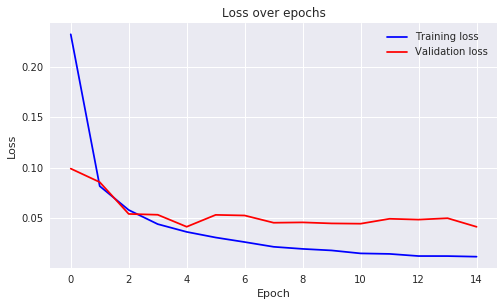

In [9]:
model, optimizer, (train_losses, val_losses, train_accs, val_accs) = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

In [44]:
save_path = "models_base/model_lenet"+ str(curr_fold) + ".pth"
torch.save(model.state_dict(), save_path)

file = open("models_base/res_"+str(curr_fold) + ".txt", "w")
file.write(str(train_losses) + "\n")
file.write(str(val_losses) + "\n")
file.write(str(train_accs) + "\n")
file.write(str(val_accs) + "\n")

file.close()

In [10]:
torch.save(model.state_dict(), "models_base/model_mnist.pth")
torch.save(optimizer.state_dict(), "models_base/model_mnist_optimizer.pth")

In [36]:
print(kfold_val_acc)

[[93.57], [tensor(0.7927, device='cuda:0'), tensor(0.8660, device='cuda:0'), tensor(0.9001, device='cuda:0'), tensor(0.9155, device='cuda:0'), tensor(0.9222, device='cuda:0'), tensor(0.9255, device='cuda:0'), tensor(0.9244, device='cuda:0'), tensor(0.9367, device='cuda:0'), tensor(0.9336, device='cuda:0'), tensor(0.9322, device='cuda:0'), tensor(0.9399, device='cuda:0'), tensor(0.9388, device='cuda:0'), tensor(0.9343, device='cuda:0'), tensor(0.9363, device='cuda:0'), tensor(0.9357, device='cuda:0')]]


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

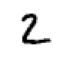

In [37]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.data[index], cmap='gray_r')
    
    with torch.no_grad():
        model.eval()
        _, probs = model(valid_dataset[index][0].unsqueeze(0))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - predictions');

## Fine-tuning on MNIST

In [26]:
mnist_model = "models_base/model_mnist.pth"
mnist_optimizer = "models_base/model_mnist_optimizer.pth"

torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model.load_state_dict(torch.load(mnist_model))
optimizer.load_state_dict(torch.load(mnist_optimizer))

20:27:49 --- Epoch: 0	Train loss: 0.8175	Valid loss: 0.1171	Train accuracy: 81.74	Valid accuracy: 81.16
20:30:14 --- Epoch: 1	Train loss: 0.3862	Valid loss: 0.0875	Train accuracy: 86.22	Valid accuracy: 85.72
20:32:36 --- Epoch: 2	Train loss: 0.2995	Valid loss: 0.0772	Train accuracy: 87.98	Valid accuracy: 87.52
20:35:01 --- Epoch: 3	Train loss: 0.2623	Valid loss: 0.0652	Train accuracy: 90.35	Valid accuracy: 89.49
20:37:27 --- Epoch: 4	Train loss: 0.2335	Valid loss: 0.0586	Train accuracy: 91.65	Valid accuracy: 90.64
20:39:51 --- Epoch: 5	Train loss: 0.2190	Valid loss: 0.0731	Train accuracy: 89.50	Valid accuracy: 88.82
20:42:16 --- Epoch: 6	Train loss: 0.2055	Valid loss: 0.0511	Train accuracy: 92.97	Valid accuracy: 91.86
20:44:39 --- Epoch: 7	Train loss: 0.1932	Valid loss: 0.0530	Train accuracy: 92.41	Valid accuracy: 91.43
20:47:01 --- Epoch: 8	Train loss: 0.1852	Valid loss: 0.0475	Train accuracy: 93.89	Valid accuracy: 92.40
20:49:22 --- Epoch: 9	Train loss: 0.1760	Valid loss: 0.0489	Trai

/home/mayankg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


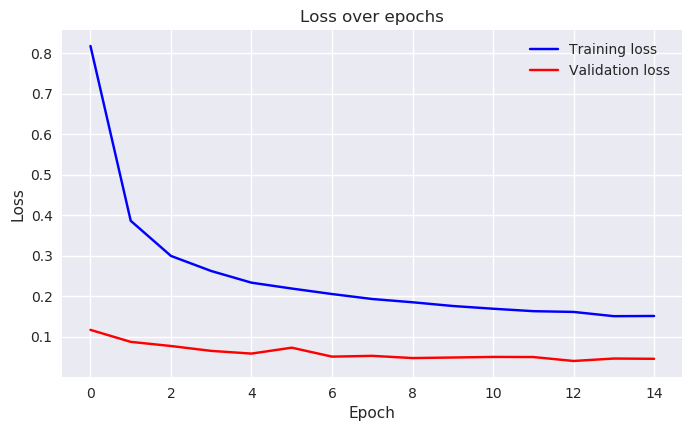

In [27]:
model, optimizer, (train_losses, val_losses, train_accs, val_accs) = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

In [21]:
save_path = "models_base/model_lenet_best"+ str(curr_fold) + ".pth"
torch.save(model.state_dict(), save_path)

file = open("models_base/res_best_"+str(curr_fold) + ".txt", "w")
file.write(str(train_losses) + "\n")
file.write(str(val_losses) + "\n")
file.write(str(train_accs) + "\n")
file.write(str(val_accs) + "\n")

file.close()